In [5]:
import keras
from keras import layers
from keras import backend as K
from keras.models import Model
import numpy as np

'''
import os
import imp
os.environ['KERAS_BACKEND'] = 'tensorflow'
imp.reload(K)
'''

img_shape = (28, 28, 1)
batch_size = 16
latent_dim = 2
input_img = keras.Input(shape=img_shape)

x = layers.Conv2D(32, 3,
            padding='same', activation='relu')(input_img)
x = layers.Conv2D(64, 3,
            padding='same', activation='relu',strides=(2, 2))(x)
x = layers.Conv2D(64, 3,
            padding='same', activation='relu')(x)
x = layers.Conv2D(64, 3,
            padding='same', activation='relu')(x)

shape_before_flattening = K.int_shape(x)

x = layers.Flatten()(x)
x = layers.Dense(32, activation='relu')(x)
z_mean = layers.Dense(latent_dim)(x)
z_log_var = layers.Dense(latent_dim)(x)


In [6]:
def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim),
                                mean=0., stddev=1.)
    
    return z_mean + K.exp(z_log_var) * epsilon

z = layers.Lambda(sampling)([z_mean, z_log_var])

In [7]:
decoder_input = layers.Input(K.int_shape(z)[1:])

x = layers.Dense(np.prod(shape_before_flattening[1:]),
                activation='relu')(decoder_input)
x = layers.Reshape(shape_before_flattening[1:])(x)
x = layers.Conv2DTranspose(32, 3,
                            padding='same',
                            activation='relu',
                            strides=(2, 2))(x)
x = layers.Conv2D(1, 3,padding='same',
                activation='sigmoid')(x)

decoder = Model(decoder_input, x)

z_decoded = decoder(z)

In [8]:
class CustomVariationalLayer(keras.layers.Layer):
    def vae_loss(self, x, z_decoded):
        x = K.flatten(x)
        z_decoded = K.flatten(z_decoded)
        xent_loss = keras.metrics.binary_crossentropy(x, z_decoded)
        kl_loss = -5e-4 * K.mean(
                        1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
        return K.mean(xent_loss + kl_loss)

    def call(self, inputs):
        x = inputs[0]
        z_decoded = inputs[1]
        loss = self.vae_loss(x, z_decoded)
        self.add_loss(loss, inputs=inputs)
        return x

y = CustomVariationalLayer()([input_img, z_decoded])

In [9]:
from keras.datasets import mnist

vae = Model(input_img, y)
vae.compile(optimizer='rmsprop', loss=None)
vae.summary()
(x_train, _), (x_test, y_test) = mnist.load_data()
x_train = x_train.astype('float32') / 255.
x_train = x_train.reshape(x_train.shape + (1,))
x_test = x_test.astype('float32') / 255.
x_test = x_test.reshape(x_test.shape + (1,))

vae.fit(x=x_train, y=None,
            shuffle=True,
            epochs=2,
            batch_size=batch_size,
            validation_data=(x_test, None))


/home/rajat/anaconda2/envs/keras35/lib/python3.5/site-packages/ipykernel_launcher.py:4: UserWarning: Output "custom_variational_layer_1" missing from loss dictionary. We assume this was done on purpose, and we will not be expecting any data to be passed to "custom_variational_layer_1" during training.
  after removing the cwd from sys.path.


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
conv2d_9 (Conv2D)               (None, 28, 28, 32)   320         input_4[0][0]                    
__________________________________________________________________________________________________
conv2d_10 (Conv2D)              (None, 14, 14, 64)   18496       conv2d_9[0][0]                   
__________________________________________________________________________________________________
conv2d_11 (Conv2D)              (None, 14, 14, 64)   36928       conv2d_10[0][0]                  
__________________________________________________________________________________________________
conv2d_12 

In [10]:
import matplotlib.pyplot as plt
from scipy.stats import norm
n = 15
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))
grid_x = norm.ppf(np.linspace(0.05, 0.95, n))
grid_y = norm.ppf(np.linspace(0.05, 0.95, n))

for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])
        z_sample = np.tile(z_sample, batch_size).reshape(batch_size, 2)
        x_decoded = decoder.predict(z_sample, batch_size=batch_size)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size,
              j * digit_size: (j + 1) * digit_size] = digit

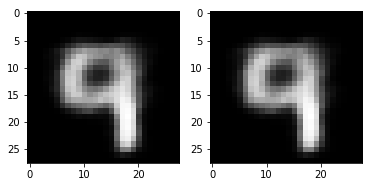

In [18]:
plt.subplot(121)
plt.imshow(x_decoded[10,:,:,0], cmap='Greys_r')
plt.subplot(122)
plt.imshow(x_decoded[12,:,:,0], cmap='Greys_r')

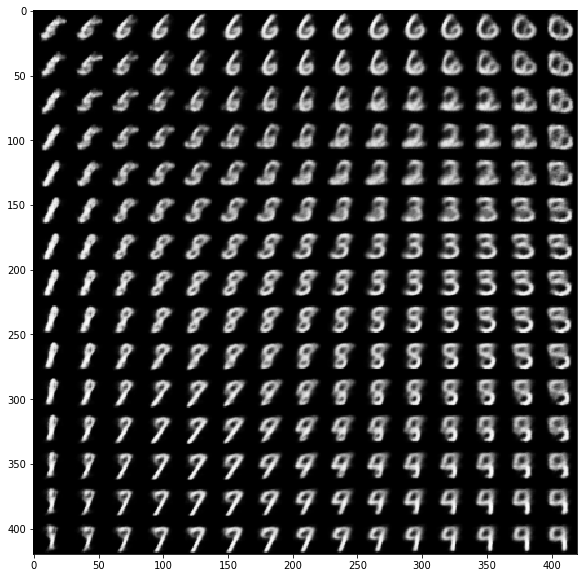

In [11]:
%matplotlib inline
plt.figure(figsize=(10, 10))
plt.imshow(figure, cmap='Greys_r')
plt.show()

In [1]:
# GANs

import keras
from keras import layers
import numpy as np

latent_dim = 32
height = 32
width = 32
channels = 3

generator_input = keras.Input(shape=(latent_dim,))
x = layers.Dense(128 * 16 * 16)(generator_input)
x = layers.LeakyReLU()(x)
x = layers.Reshape((16, 16, 128))(x)

x = layers.Conv2D(256, 5, padding='same')(x)
x = layers.LeakyReLU()(x)

x = layers.Conv2DTranspose(256, 4, strides=2, padding='same')(x)
x = layers.LeakyReLU()(x)

x = layers.Conv2D(256, 5, padding='same')(x)
x = layers.LeakyReLU()(x)
x = layers.Conv2D(256, 5, padding='same')(x)
x = layers.LeakyReLU()(x)

x = layers.Conv2D(channels, 7, activation='tanh', padding='same')(x)
generator = keras.models.Model(generator_input, x)
generator.summary()

/home/rajat/anaconda2/envs/keras35/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 32768)             1081344   
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 32768)             0         
_________________________________________________________________
reshape_1 (Reshape)          (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 16, 256)       819456    
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 16, 16, 256)       0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 32, 32, 256)       1048832   
__________

In [2]:
discriminator_input = layers.Input(shape=(height, width, channels))
x = layers.Conv2D(128, 3)(discriminator_input)
x = layers.LeakyReLU()(x)
x = layers.Conv2D(128, 4, strides=2)(x)
x = layers.LeakyReLU()(x)
x = layers.Conv2D(128, 4, strides=2)(x)
x = layers.LeakyReLU()(x)
x = layers.Conv2D(128, 4, strides=2)(x)
x = layers.LeakyReLU()(x)
x = layers.Flatten()(x)
x = layers.Dropout(0.4)(x)
x = layers.Dense(1, activation='sigmoid')(x)

discriminator = keras.models.Model(discriminator_input, x)
discriminator.summary()

discriminator_optimizer = keras.optimizers.RMSprop(
              lr=0.0008,
              clipvalue=1.0,
              decay=1e-8)
discriminator.compile(optimizer=discriminator_optimizer,
              loss='binary_crossentropy')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 30, 30, 128)       3584      
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 30, 30, 128)       0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 14, 14, 128)       262272    
_________________________________________________________________
leaky_re_lu_7 (LeakyReLU)    (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 6, 6, 128)         262272    
_________________________________________________________________
leaky_re_lu_8 (LeakyReLU)    (None, 6, 6, 128)         0         
__________

In [3]:
discriminator.trainable = False

gan_input = keras.Input(shape=(latent_dim,))
gan_output = discriminator(generator(gan_input))
gan = keras.models.Model(gan_input, gan_output)

gan_optimizer = keras.optimizers.RMSprop(lr=0.0004, clipvalue=1.0, decay=1e-8)
gan.compile(optimizer=gan_optimizer, loss='binary_crossentropy')

In [4]:
import os
from keras.preprocessing import image

(x_train, y_train), (_, _) = keras.datasets.cifar10.load_data()
x_train = x_train[y_train.flatten() == 6]

x_train = x_train.reshape(
                        (x_train.shape[0],) +
                        (height, width, channels)).astype('float32') / 255.
iterations = 10000
batch_size = 20

# create a directory from where you are running this notebook
save_dir = './gan_imgs'

start = 0

for step in range(iterations):
    random_latent_vectors = np.random.normal(size=(batch_size,
                                                   latent_dim))
    generated_images = generator.predict(random_latent_vectors)
    
    stop = start + batch_size
    real_images = x_train[start: stop]
    combined_images = np.concatenate([generated_images, real_images])
    
    labels = np.concatenate([np.ones((batch_size, 1)),np.zeros((batch_size, 1))])
    labels += 0.05 * np.random.random(labels.shape)
    
    d_loss = discriminator.train_on_batch(combined_images, labels)
    random_latent_vectors = np.random.normal(size=(batch_size,latent_dim))
    misleading_targets = np.zeros((batch_size, 1))
    a_loss = gan.train_on_batch(random_latent_vectors,misleading_targets)
    
    start += batch_size
    if start > len(x_train) - batch_size:
        start = 0
        
    if step % 100 == 0:
        gan.save_weights('gan.h5')
        print('discriminator loss:', d_loss)
        print('adversarial loss:', a_loss)
        
        img = image.array_to_img(generated_images[0] * 255., scale=False)
        img.save(os.path.join(save_dir,'generated_frog' + str(step) + '.png'))
        
        img = image.array_to_img(real_images[0] * 255., scale=False)
        img.save(os.path.join(save_dir, 'real_frog' + str(step) + '.png'))

/home/rajat/anaconda2/envs/keras35/lib/python3.5/site-packages/keras/engine/training.py:973: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


discriminator loss: 0.70619917
adversarial loss: 0.27896744
discriminator loss: 7.554334
adversarial loss: 15.942385
discriminator loss: 7.6019983
adversarial loss: 15.942385
discriminator loss: 7.5559435
adversarial loss: 15.942385
discriminator loss: 7.5485163
adversarial loss: 15.942385
discriminator loss: 7.537713
adversarial loss: 15.942385
discriminator loss: 7.5460343
adversarial loss: 15.942385
discriminator loss: 7.53337
adversarial loss: 15.942385
discriminator loss: 7.555484
adversarial loss: 15.942385


KeyboardInterrupt: 